<center><font size = "10"> Week 4 - Ion Channels <center>
<center><font size = "8">Home work SOLUTIONS<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: ELiser Josan Romero

In [10]:
# libraries used
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.optimize import curve_fit


# Ex1. Extracting parameters from experimental data

<font size=3>

You have been provided with a .nwb file describing measurements of a potassium channel.
The Activiation protocol contains current traces for an ion channel voltage clamped at potentials between -90 mV and +80 mV, at 10mV intervals.

Plot each of the traces and inspect them.
For each trace identify the maximum current $I_{max}$ and the activation time constant $ \tau_m $.
You can find $\tau_m$ at each potential value by fitting an exponential function $\displaystyle y = a + b e^{\frac{-x}{\tau_{m}}} $ to the activation curve.
Fit each trace between some start time of your choice (choose carefully) and the point of maximum ionic current.

    
Finally, plot $tau_m$ and $I_k$ against membrane potential (on separate axes). How do they vary with voltage? What does this mean for the behavior of the channel?

[2 pts]



In [11]:
# Open data with python
data_path = 'Group8/ion_channel.nwb'

data = h5py.File(data_path, 'r')
print(*data.keys())
print(data['session_description'][0])

acquisition analysis checksums epochs file_create_date general identifier nwb_version processing session_description session_start_time stimulus
b'4 runs with CHO rKv1.6 at 25c.'


In [12]:
list(data['acquisition']['timeseries'].keys())

['AP',
 'Activation',
 'Deactivation',
 'Inactivation',
 'Ramp',
 'Recovery',
 'VRest']

## Plotting activation trace

In [13]:
# setting plotting functions

def plot_timeseries(timeseries_repetition):
    traces = np.array(timeseries_repetition['data']).transpose()
    if 'x_interval' in timeseries_repetition:
        dts = np.array(timeseries_repetition['x_interval'])
    else:
        dts = np.array((len(traces), ))
    fig = plt.figure()
    ax = plt.subplot(111)
    n=1
    for trace, dt in zip(traces, dts):
        time = np.linspace(0, len(trace) * dt, len(trace))
        ax.plot(time, trace, label='trace: %.0f' %(n)) #label=label)
        n+=1
    plt.legend()
    plt.title(timeseries_repetition.name)
    plt.xlabel("Time (s)")
    plt.ylabel("Current (pA)")
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
        

def plot_recurse(group):
    for k, grp in group.items():
        if hasattr(grp, 'items'):
            if 'data' in grp:
                plot_timeseries(grp)
            else:
                plot_recurse(grp)

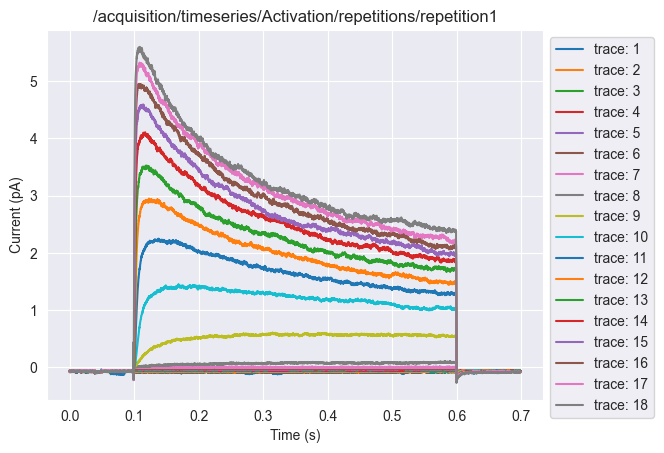

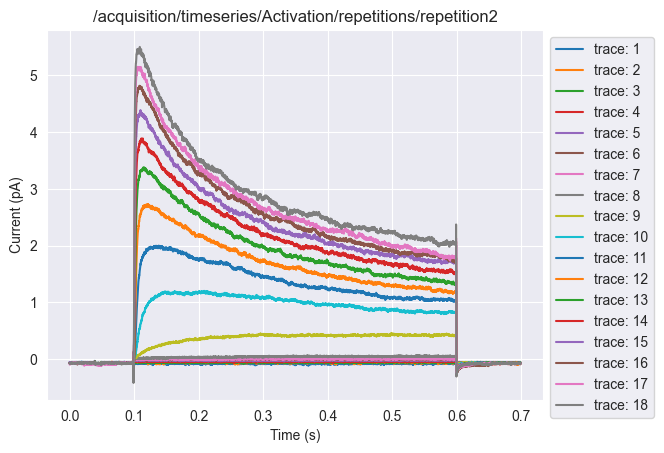

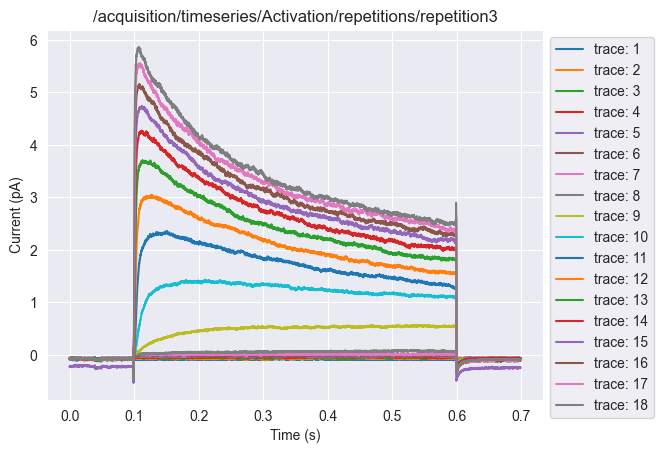

In [14]:
# plot
plot_recurse(data['acquisition']['timeseries']['Activation'])

## Fitting

In [15]:
# looking for directory of data arrays in nwb file
list(data['acquisition']['timeseries']['Activation']['repetitions']['repetition1'].keys())

['amp',
 'capacitance_slow',
 'data',
 'head_temp',
 'n_points',
 'r_series',
 'seal',
 'starting_time',
 'time',
 'trace_ids',
 'trace_times',
 'v_offset',
 'x_interval',
 'x_start']

In [16]:
data['acquisition']['timeseries']['Activation']['repetitions']['repetition1']['data'].shape

(6990, 18)

In [28]:
def func_exp(x, tau):
    return 1 - np.exp(-x/tau)

def plot_exponential_fit(x_data, y_data):
    '''Fit an exponential function to the data in file_name and plot the result.'''
    
    # In this case, we want to compute TAU = popt[0]
    # and to quantify the fitting quality we want to know perr
    popt, pcov = curve_fit(func_exp, x_data, y_data)
    perr = np.sqrt(np.diag(pcov))
    
    plt.figure(figsize=(10,6))
    plt.plot(x_data, y_data, 'xk', label='original data' )
    plt.plot(x_data, func_exp(x_data, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
    plt.legend()
    plt.show()
    
def plot_fits(data, pathway, rep):
    traces = pd.DataFrame(data[pathway+'/repetition'+str(rep)+'/data'])
    dts = np.array(data[pathway+'/repetition'+str(rep)+'/x_interval'])
    starts = np.array(data[pathway+'/repetition'+str(rep)+'/x_start'])
    #dts = np.array((len(traces), ))
    nRow, nCol = traces.shape
    x_end = starts[0] + dts[0]*(float(nRow - 1))
    time = np.linspace(starts[0], x_end, nRow)*1000
    for i in range(nCol):
        plot_exponential_fit(time, traces[i]) #label=label)
    
    """
    for trace, dt in zip(traces.itertuples(), dts):
        time = np.linspace(0, len(trace) * dt, len(trace))
        plot_exponential_fit(time, trace) #label=label)
    """
    plt.title(pathway+'/repetition'+str(rep))
    plt.xlabel("Time (s)")
    plt.ylabel("Current (pA)")
                

In [32]:
# for repetition 1
pathway = 'acquisition/timeseries/Activation/repetitions'
repetition = 1
plot_fits(data, pathway, repetition)


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [34]:
protocolName = 'Activation'
repID = '1'

In [62]:


def plotDataFiles(data_pathway, pathway, repID):
    ''' Function .....
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number
    :param byTraces: if true, represent each trace in one figure'''
    
    # Open the file
    open_data = h5py.File(data_pathway, 'r')
    
    # Select on strings what do we want for ploting
    string_data = pathway + str(repID) +'/data'
    string_xinterval = pathway + str(repID) +'/x_interval'
    string_xstart = pathway + str(repID) +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)]
    x_interval = open_data[(string_xinterval)]
    x_start = open_data[(string_xstart)]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    # each trace in different figures
    data_t = np.transpose(data)
    i = 0
    taus = []
    for trace in data_t:  
        def func_exp(x, tau):
            return np.amax(trace[1010:5991])-(np.amax(trace[1010:5991])-trace[1010])*np.exp(-x/tau)
        plt.figure()
        plt.title('%s repetition %s , trace %s' %(protocolName, repID,i))
        plt.ylabel('voltage traces (mV)')
        plt.xlabel('time (ms)')
        rank_max = np.argmax(trace[1010:5991])+1010
        plt.plot(time[1010:rank_max], trace[1010:rank_max], 'b')
        popt, pcov = curve_fit(func_exp, np.concatenate(time)[1010:rank_max]-102, trace[1010:rank_max])
        taus+=[popt[0]]
        perr = np.sqrt(np.diag(pcov))
        plt.plot(time[1010:rank_max], func_exp(time[1010:rank_max]-102, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
        plt.legend()
        i = i + 1
        plt.show()
    return taus

C:\Users\josan\AppData\Local\Temp\ipykernel_28016\2938330191.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(time[1010:rank_max], func_exp(time[1010:rank_max]-102, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))


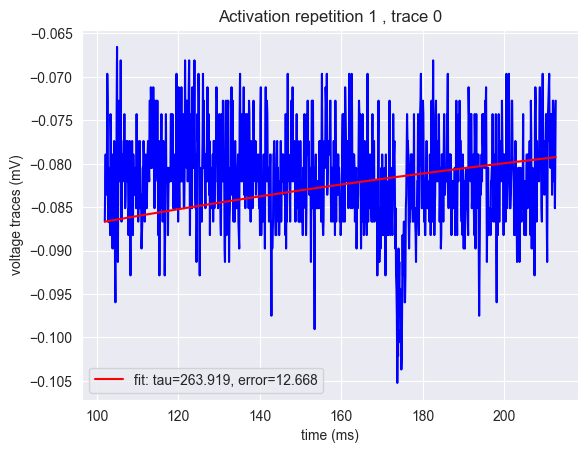

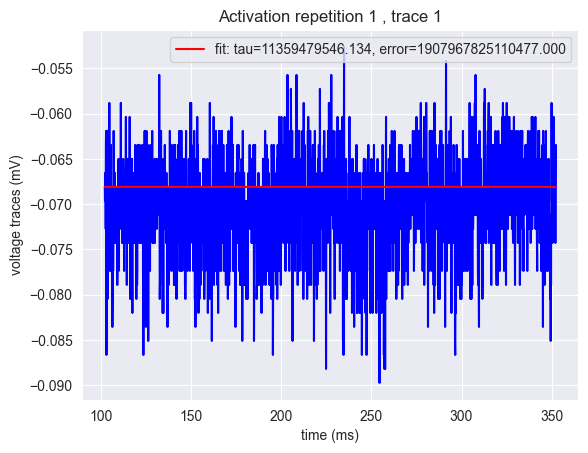

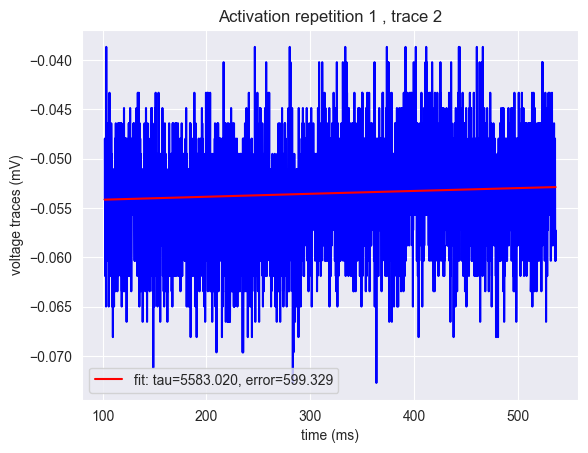

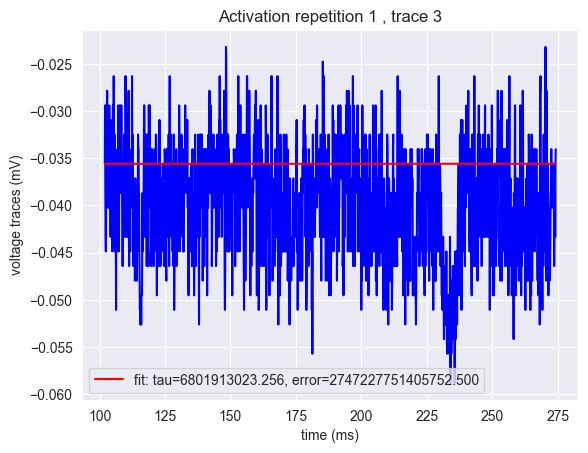

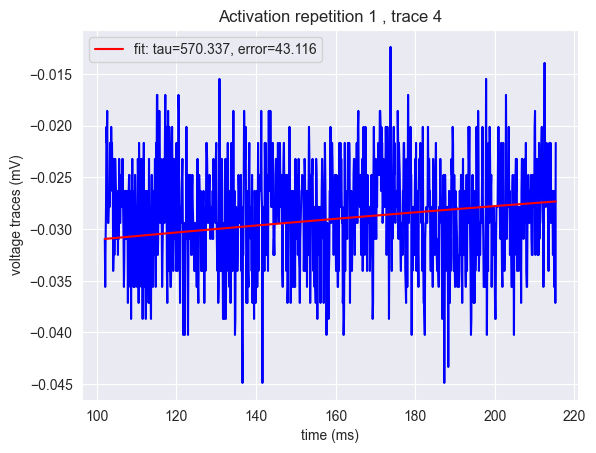

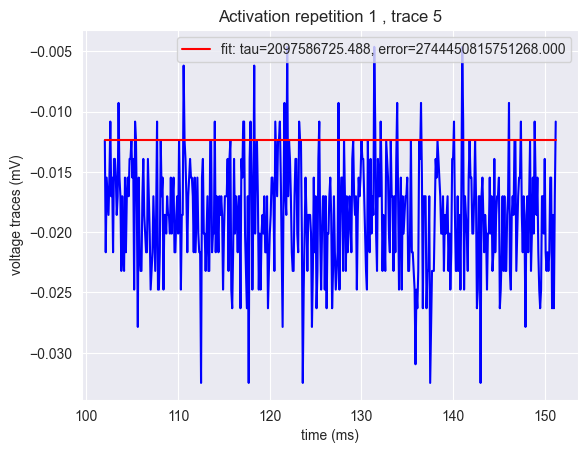

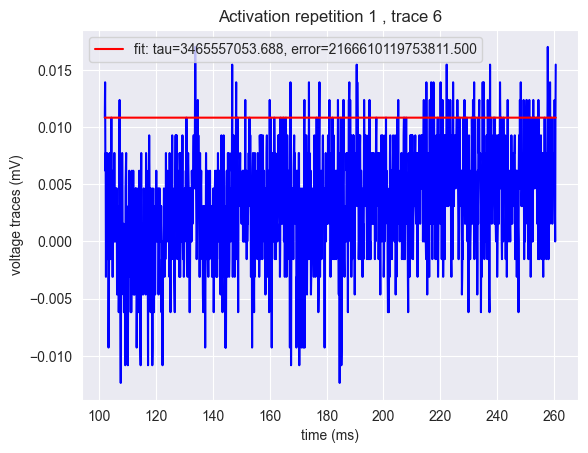

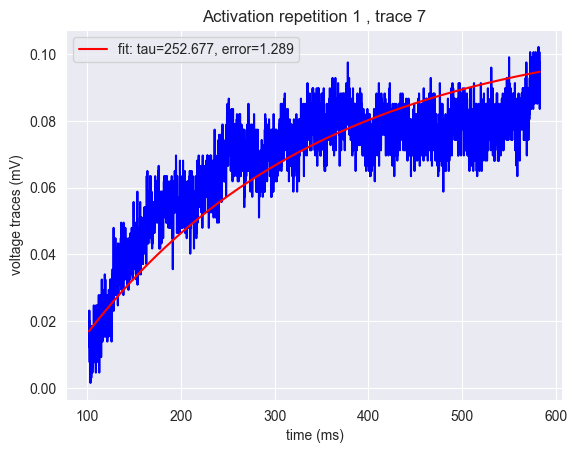

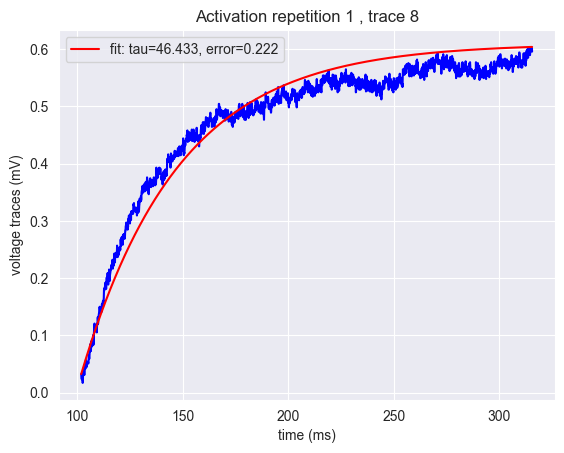

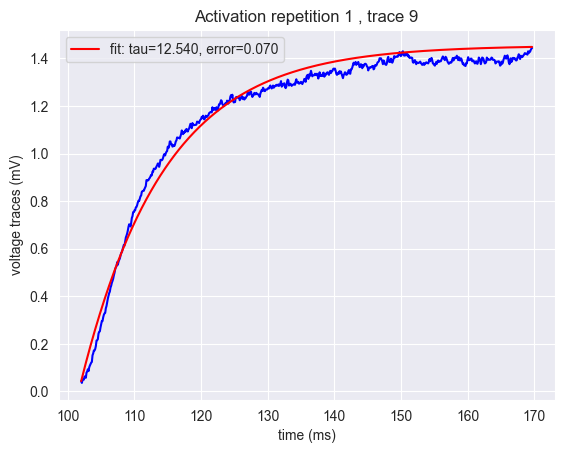

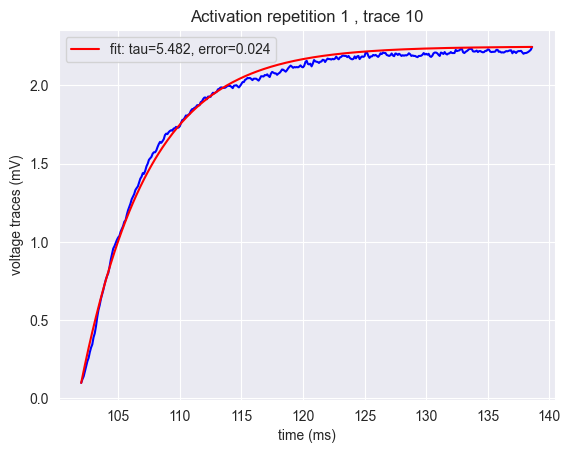

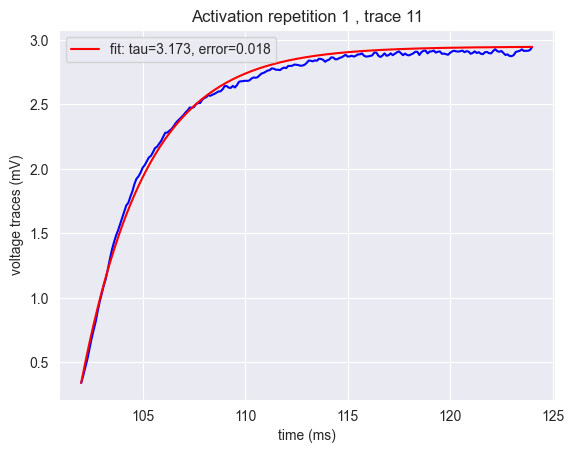

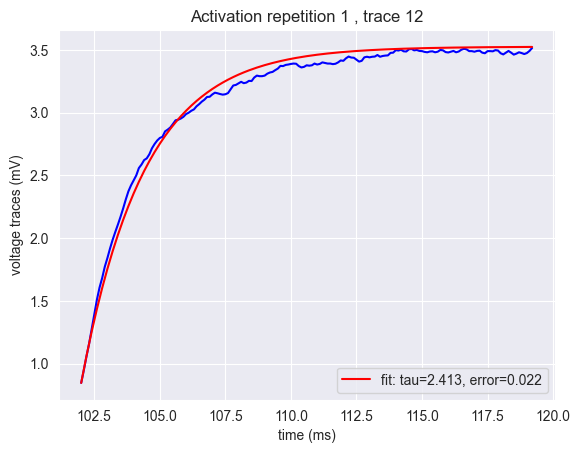

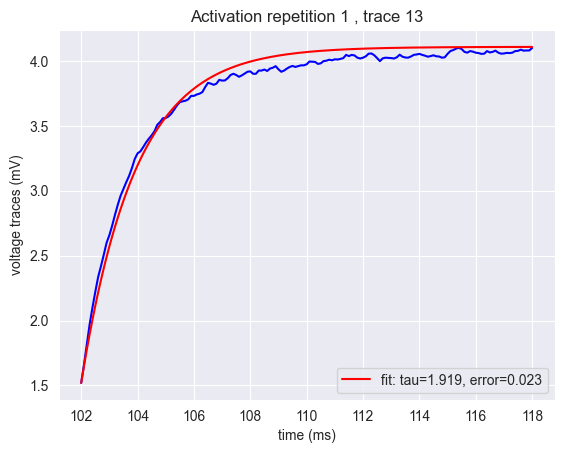

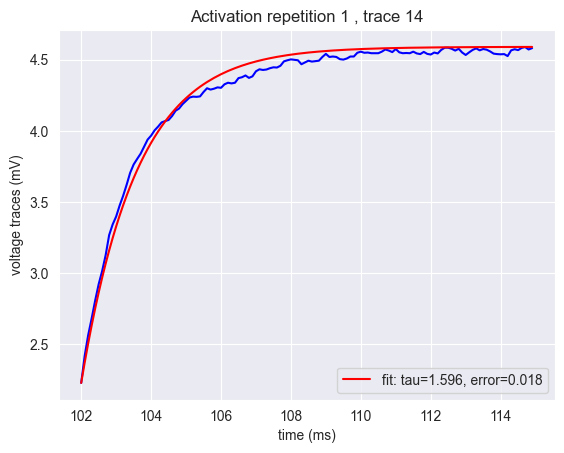

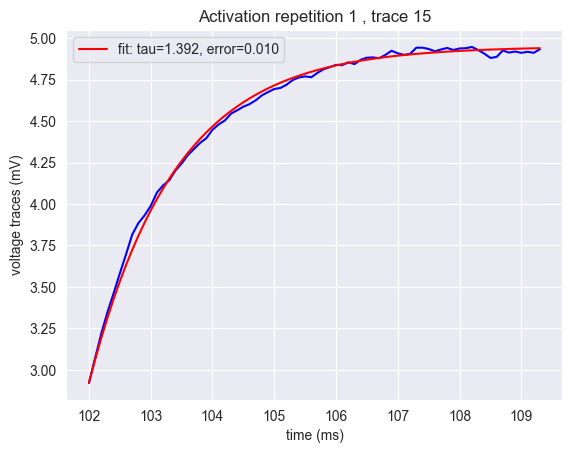

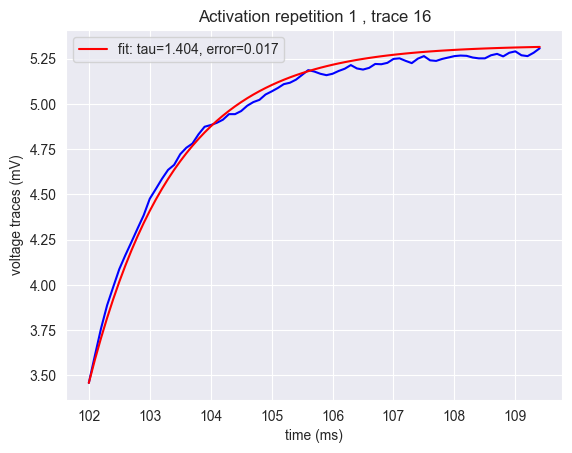

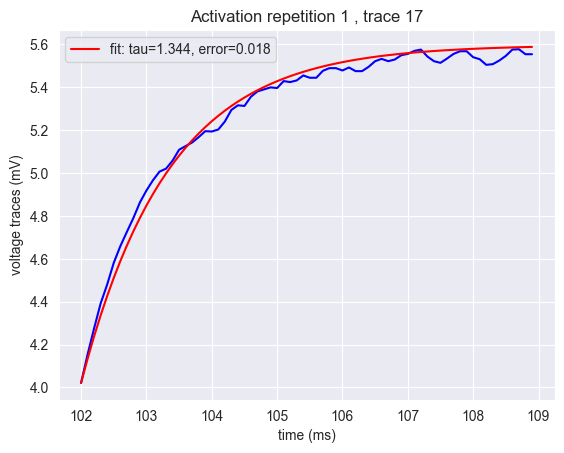

In [66]:
# for repetition 1
pathway = '/acquisition/timeseries/Activation/repetitions/repetition'
repetition = 1
taus=plotDataFiles(data_path, pathway, repetition)

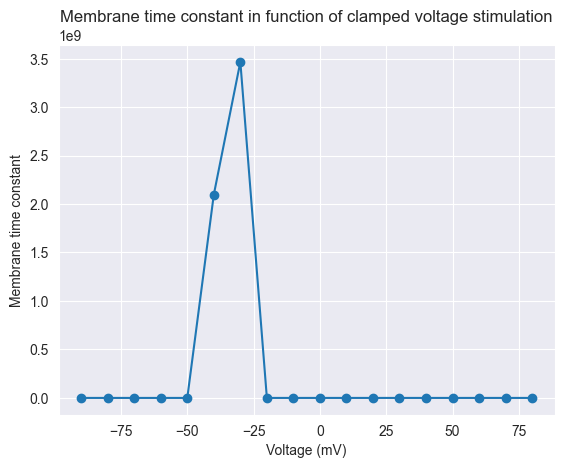

In [67]:
mV=np.linspace(-90,80,18)
for i in range (4) :
    taus[i]=0

plt.figure()
plt.plot(mV,taus)
plt.scatter(mV,taus)
plt.title('Membrane time constant in function of clamped voltage stimulation')
plt.ylabel('Membrane time constant')
plt.xlabel('Voltage (mV)')
plt.show()

> The time constant tau represents the time constant of the membrane, it is the time to achieve a 63% change in the membrane voltage. Tau depends on the capacitive properties of the membrane: Tau = Rm\*Cm, where Cm is the capacitance and R the resistance of the membrane. 
Physically, it is the time constant of the channel at different voltage steps, it depends on the time it takes for the channel to open.

# Ex2. Implementing a Potassium channel

<font size=3>

See `SKv3.1.mod`. Your task is to fill it in to implement the following potassium channel model:

$\displaystyle I_K = g_k \times (v - E_k)$
    
Where $I_k$ is potassium current, v is membrane potential, $g_k$ the potassium conductance, and $E_k$ is the reversal potential of potassium (provided for you within the NEURON simulator).

$\displaystyle g_k = \bar{g_k} \times m $
    
Where $\bar{g_k}$ is the maximum potassium conductance and m evolves according to the differential equation:

$\displaystyle m' = \frac{(m_{inf} - m)}{\tau_m}$

$\displaystyle m_{inf} = \frac{1}{1 + e^{\frac{v - v_{half}}{ s_m}}}$
    
$\displaystyle \tau_m = \frac{c_{\tau}}{1 + e^{\frac{v - v_{\tau}}{s_{\tau}}}} $
    
With some values fixed:
    
$s_m = -9.7$
    
$c_{\tau} = 4$
    
$\bar{g_k} = 0.0001 Scm^{-2}$

$v_{\tau} =  -46.560 V$
    
$s_{\tau} = -44$

The remaining parameter, $v_{half}$ we will vary.
    
Next, Create a cell in Neuron with the following characteristics: 
    
 - 1 section (soma) with one segment 15 µm of length and diameter, 
 - 120 Ω*cm of axial radius and 
 - 1.6 µF/cm^2 of capacitance. 
    
Insert the channel you just created.
Add a current clamp stimulus starting at 100ms and lasting 500ms.
    
Vary vhalf for to the values -30, -20, -10, 0, 10, 20. 
For each value of vhalf, vary stimulus amplitude between 0 and 1.5.
Record the maximum membrane potential and potassium conductance for each.
    
plot the I/V curves for each v_half on the same axes. 
explain the meaning of the results.

[2 pts]
    

# Ex3. Finding the rheobase of a cell

<font size = "3"> 
Create a cell in Neuron with the following characteristics: 
    
 - 1 section (soma) with one segment 15 µm of length and diameter, 
 - 120 Ω*cm of axial radius and 
 - 1.6 µF/cm^2 of capacitance. 

Add active sodium and potassium channels using the hodgekin-huxley (hh) mechanism. Set (gNa = 0.09 S and gK = 0.01 S).
hh also includes a passive conductance driving the neuron to its resting potential.
Set hh.el to -70 mV and hh.gl to 0.003 S/cm^2. 
    
Generate a current clamp experiment in which you inject 0.016 mA current into the cell soma with 50 ms delay, 500ms in duration. Use a voltage base of -70 mV and set the total recording duration of the experiment to 800ms. This is your base experiment - plot the injected current and the resulting membrane potential. Vary the injected current to find the rheobase of this cell - what is its amplitude ? What is the threshold potential for this cell? 

Next, inject the rheobase current into the cell for 60 ms followed 200ms later by double rheobase current for only 30ms. Plot the voltage trace. What do you see? Why does this effect occur?
    
Finally, inject rheobase as in the first experiment but vary the sodium conductance with values 0.08, 0.09, 0.12. Plot the voltage traces. Is the excitability of the cell very sensitive to this parameter? How does this relate to the role of sodium channels in action potential generation?
    
<font size = "3">[2 pt]